# Titanic - Machine Learning from Disaster
## LB=0.82535 (Top 3%) 

This model is original from : Vitalii Mokin 
https://www.kaggle.com/vbmokin/titanic-0-83253-comparison-20-popular-models. 

Basen on original model and put some imporvment what I discovered to get LB=0.82296

Update
2021.07.01 : Using voting model from : LD Freeman 
https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy. 
To get LB=0.82535

# 1. Data Preparation

In [1]:
import pandas as pd
import numpy as np 
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Download data and preparing to prediction
traindf = pd.read_csv('../input/titanic/train.csv').set_index('PassengerId')
testdf = pd.read_csv('../input/titanic/test.csv').set_index('PassengerId')
df = pd.concat([traindf, testdf], axis=0, sort=False)

# 2. Features Engineering (FE)

In [3]:
df.isna().sum()

Survived     418
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

## 2.1 Title

In [4]:
newtitles={
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"}

# Extract title from name column
df['Title']=df.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())
# Mapping new title
df['Title']=df.Title.map(newtitles)
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Royalty', 'Officer'], dtype=object)

In [5]:
pd.crosstab(df['Title'],df['Survived']).T.style.background_gradient(cmap='summer_r')

Title,Master,Miss,Mr,Mrs,Officer,Royalty
Survived,,,,,,
0.0,17,55,436,26,13,2
1.0,23,129,81,101,5,3


## 2.2 Gender 

In [6]:
# Created a new column : "Gender", to seperate male, femail and kid
# Note : If create "Gender" column after "Age", it can only get LB=0.82057, because "Age" will fill missing value.

def newgender (cols):
    Sex=cols[0]
    Age=cols[1]
    if Age < 15:
        return 'kid'
    else:
        return Sex
    
df['Gender'] = df[['Sex','Age']].apply(newgender, axis=1)

## 2.3 Age

In [7]:
df.groupby(['Title','Sex']).Age.mean()

Title    Sex   
Master   male       5.482642
Miss     female    21.795236
Mr       male      32.252151
Mrs      female    36.866279
Officer  female    49.000000
         male      46.142857
Royalty  female    40.000000
         male      42.333333
Name: Age, dtype: float64

In [8]:
def newage (cols):
    title=cols[0]
    Sex=cols[1]
    Age=cols[2]
    if pd.isnull(Age):
        if title=='Master' and Sex=="male":
            return 5.48
        elif title=='Miss' and Sex=='female':
            return 21.79
        elif title=='Mr' and Sex=='male': 
            return 32.25
        elif title=='Mrs' and Sex=='female':
            return 36.86
        elif title=='Officer' and Sex=='female':
            return 49
        elif title=='Officer' and Sex=='male':
            return 46.12
        elif title=='Royalty' and Sex=='female':
            return 40
        else:
            return 42.33
    else:
        return Age
    
df['Age']=df[['Title','Sex','Age']].apply(newage, axis=1)

## 2.4 IsWomanOrBoy & LastName

In [9]:
df['IsWomanOrBoy'] = ((df.Age < 15) | (df.Sex == 'female'))
df['LastName'] = df.Name.str.split(',').str[0]

## 2.5 WomanOrBoySurvived By Last Name

In [10]:
# Calculate each family's female and kids survival rate by family's last name
family = df.groupby(df.LastName).Survived
df['F_TotalCount'] = family.transform(lambda s: s.count())
df['F_WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
df['F_WomanOrBoyCount'] = df.mask(df.IsWomanOrBoy, df.F_WomanOrBoyCount - 1, axis=0)
df['F_FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
df['F_FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.F_FamilySurvivedCount - df.Survived.fillna(0), axis=0)
df['F_WomanOrBoySurvived'] = df.F_FamilySurvivedCount / df.F_WomanOrBoyCount.replace(0, np.nan)
df['F_WomanOrBoySurvived'] = df.F_WomanOrBoySurvived.fillna(0)
df['F_Alone'] = (df.F_WomanOrBoyCount == 0)

## 2.6 WomanOrBoySurvived By Ticket

In [11]:
# Calculate each family's female and kids survival rate by ticket number
ticket = df.groupby(df.Ticket).Survived
df['T_TotalCount'] = ticket.transform(lambda s: s.count())
df['T_WomanOrBoyCount'] = ticket.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
df['T_WomanOrBoyCount'] = df.mask(df.IsWomanOrBoy, df.T_WomanOrBoyCount - 1, axis=0)
df['T_FamilySurvivedCount'] = ticket.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
df['T_FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.T_FamilySurvivedCount - df.Survived.fillna(0), axis=0)
df['T_WomanOrBoySurvived'] = df.T_FamilySurvivedCount / df.T_WomanOrBoyCount.replace(0, np.nan)
df['T_WomanOrBoySurvived'] = df.T_WomanOrBoySurvived.fillna(0)
df['T_Alone'] = (df.T_WomanOrBoyCount == 0)

## 2.7 WomanOrBoySurvived & Alone

In [12]:
df['WomanOrBoySurvived'] = df[['F_WomanOrBoySurvived','T_WomanOrBoySurvived']].max(axis=1)
df['Alone'] = ((df.F_Alone) & (df.T_Alone))

## 2.8 Fare

In [13]:
med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df['Fare'] = df['Fare'].fillna(med_fare)

## 2.9 FareOne

In [14]:
# Calculate fare for single person and assume fare free for age under 1
fare = df.groupby(df.Ticket).Fare
df['FareOne'] = fare.transform(lambda x: x.mean() / x[df.Age > 1].count())
df.sort_values(by = 'FareOne', ascending = False)['FareOne'].head(5)

PassengerId
1235    128.082300
259     128.082300
738     128.082300
680     128.082300
300      82.506933
Name: FareOne, dtype: float64

In [15]:
df[df['LastName'] == "Sandstrom"]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,F_WomanOrBoySurvived,F_Alone,T_TotalCount,T_WomanOrBoyCount,T_FamilySurvivedCount,T_WomanOrBoySurvived,T_Alone,WomanOrBoySurvived,Alone,FareOne
PassengerId,,,,,,,,,,,,,,,,,,,,,
11,1.0,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7,G6,...,0.5,False,2,2.0,1.0,0.5,False,0.5,False,8.35
395,1.0,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7,G6,...,0.5,False,2,2.0,1.0,0.5,False,0.5,False,8.35
1009,NaN,3,"Sandstrom, Miss. Beatrice Irene",female,1.0,1,1,PP 9549,16.7,G6,...,1.0,False,2,2.0,2.0,1.0,False,1.0,False,8.35


## 2.10 Encoding : Gender, FareOne, Age

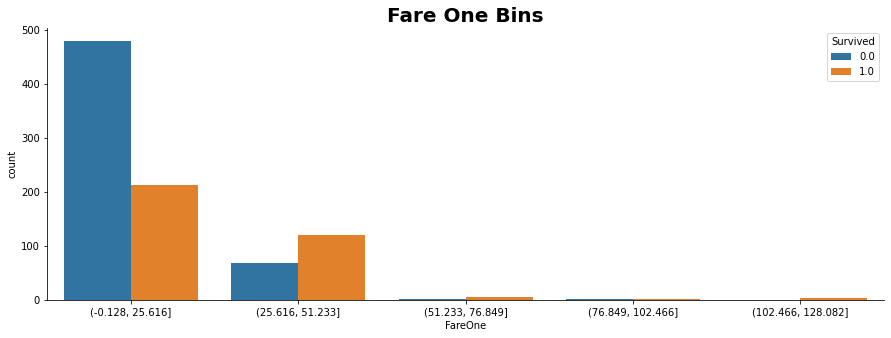

In [16]:
auxfare = pd.cut(df['FareOne'],5)
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxfare, hue='Survived', data=df).set_title("Fare One Bins",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

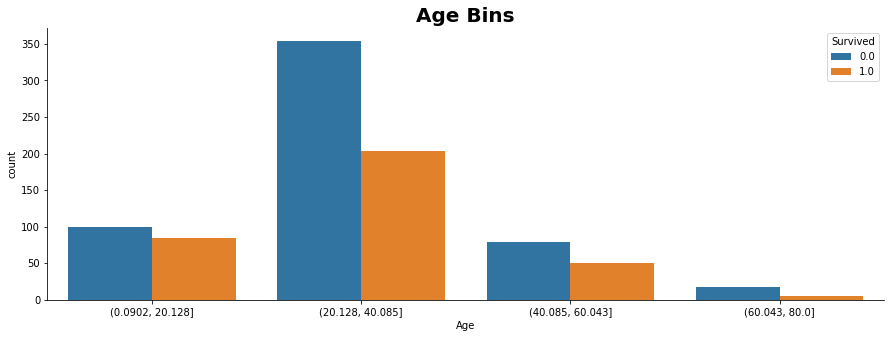

In [17]:
auxage = pd.cut(df['Age'], 4)
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxage, hue='Survived', data=df).set_title("Age Bins",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

In [18]:
df['Gender_Code'] = df.Gender.replace({'male': 0, 'female': 1, 'kid': 2})
df['FareOne_Code'] = LabelEncoder().fit_transform(auxfare) 
df['Age_Code'] = LabelEncoder().fit_transform(auxage)

In [19]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Title', 'Gender', 'IsWomanOrBoy',
       'LastName', 'F_TotalCount', 'F_WomanOrBoyCount',
       'F_FamilySurvivedCount', 'F_WomanOrBoySurvived', 'F_Alone',
       'T_TotalCount', 'T_WomanOrBoyCount', 'T_FamilySurvivedCount',
       'T_WomanOrBoySurvived', 'T_Alone', 'WomanOrBoySurvived', 'Alone',
       'FareOne', 'Gender_Code', 'FareOne_Code', 'Age_Code'],
      dtype='object')

# 3. Prepare for modeling

In [20]:
df2 = df[['Survived','WomanOrBoySurvived','Alone','Gender_Code','FareOne_Code','Age_Code']]

train, test = df2.loc[traindf.index], df2.loc[testdf.index]

train_x = train.drop(['Survived'], axis = 1)
train_y = train["Survived"]
train_names = train_x.columns

test_x = test.drop(['Survived'], axis = 1)
train_x.sort_values(by = 'WomanOrBoySurvived', ascending = True).head(10)

,WomanOrBoySurvived,Alone,Gender_Code,FareOne_Code,Age_Code
PassengerId,,,,,
1,0.0,True,0,0,1
541,0.0,False,1,1,1
545,0.0,True,0,1,2
546,0.0,True,0,1,3
547,0.0,True,1,0,0
549,0.0,True,0,0,1
550,0.0,False,2,0,0
552,0.0,True,0,0,1
553,0.0,True,0,0,1


In [21]:
# Tuning the DecisionTreeClassifier by the GridSearchCV
parameters = {'max_depth' : np.arange(2, 9, dtype=int),
              'min_samples_leaf' :  np.arange(1, 3, dtype=int)}
classifier = DecisionTreeClassifier(random_state=1000)
model = GridSearchCV(estimator=classifier, param_grid=parameters, scoring='accuracy', cv=10, n_jobs=-1)
model.fit(train_x, train_y)
best_parameters = model.best_params_
print(best_parameters)

{'max_depth': 4, 'min_samples_leaf': 1}


In [22]:
model=DecisionTreeClassifier(max_depth = best_parameters['max_depth'], 
                             min_samples_leaf = best_parameters['min_samples_leaf'], 
                             random_state = 1118)
model.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=4, random_state=1118)

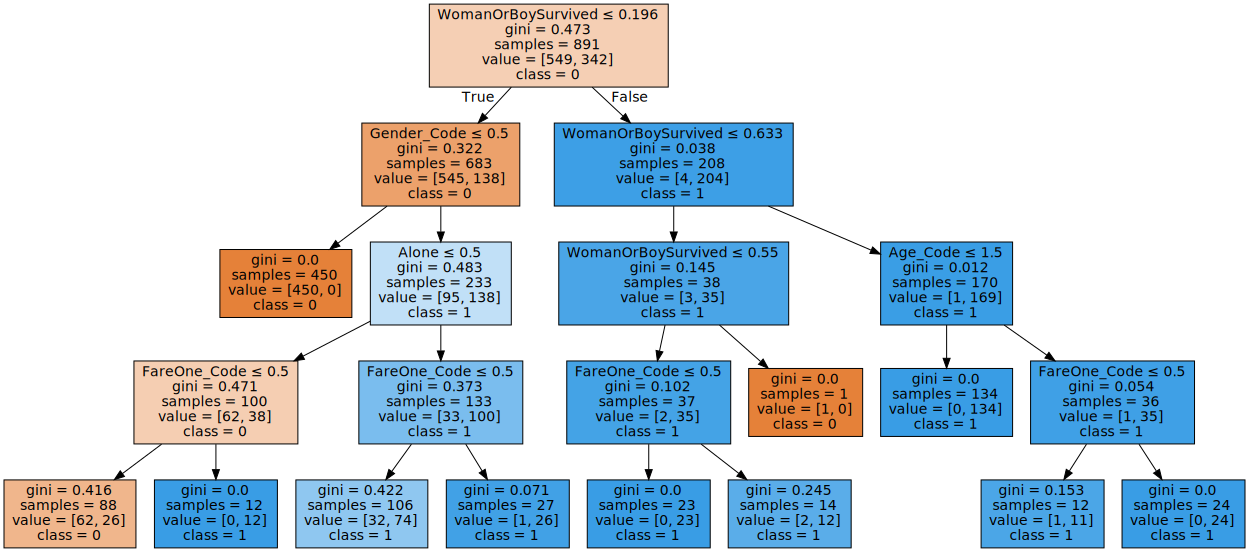

In [23]:
# plot tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
dot_data = export_graphviz(model, out_file=None, feature_names=train_names, class_names=['0', '1'], 
                           filled=True, rounded=False,special_characters=True) 
graph = graphviz.Source(dot_data)
graph 

In [24]:
# Prediction by the DecisionTreeClassifier
y_pred = model.predict(test_x).astype(int)
print("Accuracy of the model: ",round(model.score(train_x, train_y) * 100, 2))

Accuracy of the model:  93.04


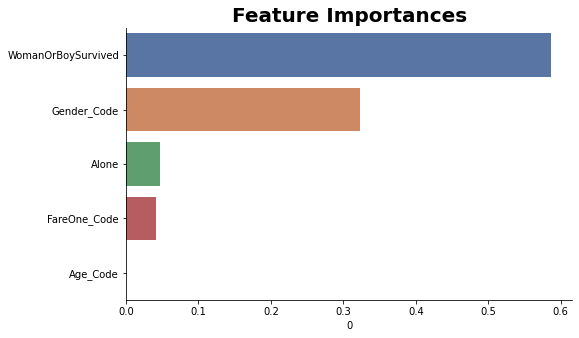

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

importances = pd.DataFrame(model.feature_importances_, index = train_names)
importances.sort_values(by = 0, inplace=True, ascending = False)
importances = importances.iloc[0:6,:] 

plt.figure(figsize=(8, 5)) 
sns.barplot(x=0, y=importances.index, data=importances,palette="deep").set_title("Feature Importances",
                                                                                 fontdict= { 'fontsize': 20,
                                                                                            'fontweight':'bold'});
sns.despine()

# 4. Voting Classifier
This voting model is original from : LD Freeman 
https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy. 

In [26]:
df5 = pd.get_dummies(df, columns=['Gender_Code','FareOne_Code'])
df5 = df5[['WomanOrBoySurvived', 'Alone', 'Age_Code', \
           'Gender_Code_0', 'Gender_Code_1', 'Gender_Code_2', \
#            'FareOne_Code_0', 'FareOne_Code_1', 'FareOne_Code_2', 'FareOne_Code_3', 'FareOne_Code_4', \
           'FareOne_Code_1', 'FareOne_Code_2', 'FareOne_Code_3', 'FareOne_Code_4', \
           'Survived']]
df5.rename(columns = {'Age_Code':'Age'}, inplace = True)
df5.rename(columns = {'Gender_Code_0':'Gender_0','Gender_Code_1':'Gender_1', 'Gender_Code_2':'Gender_2'}, inplace = True)
df5.rename(columns = {'FareOne_Code_1':'Fare_1', 'FareOne_Code_2':'Fare_2'}, inplace = True)
df5.rename(columns = {'FareOne_Code_3':'Fare_3', 'FareOne_Code_4':'Fare_4'}, inplace = True)
# df5.rename(columns = {'FareOne_Code_0':'Fare_0'}, inplace = True)
df5.columns

Index(['WomanOrBoySurvived', 'Alone', 'Age', 'Gender_0', 'Gender_1',
       'Gender_2', 'Fare_1', 'Fare_2', 'Fare_3', 'Fare_4', 'Survived'],
      dtype='object')

In [27]:
train, test = df5.loc[traindf.index], df5.loc[testdf.index]

train_x = train.drop(['Survived'], axis = 1)
train_y = train["Survived"]
train_names = train_x.columns

test_x = test.drop(['Survived'], axis = 1)
train.head(5)

,WomanOrBoySurvived,Alone,Age,Gender_0,Gender_1,Gender_2,Fare_1,Fare_2,Fare_3,Fare_4,Survived
PassengerId,,,,,,,,,,,
1,0.0,True,1,1,0,0,0,0,0,0,0.0
2,0.0,True,1,0,1,0,1,0,0,0,1.0
3,0.0,True,1,0,1,0,0,0,0,0,1.0
4,0.0,True,1,0,1,0,1,0,0,0,1.0
5,0.0,True,1,1,0,0,0,0,0,0,0.0


In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [29]:
#Common Model Algorithms
from sklearn import tree, ensemble

#why choose one model, when you can pick them all with voting classifier
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('etc',ensemble.ExtraTreesClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Decision Tree: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    ('dtc', tree.DecisionTreeClassifier())
]

In [30]:
from sklearn import model_selection

#split dataset in cross-validation with this splitter class: 
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
# run model 10x with 60/30 split intentionally leaving out 10%
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 

#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, train_x, train_y, cv=cv_split, return_train_score=True)
vote_hard.fit(train_x, train_y)

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, train_x, train_y, cv=cv_split, return_train_score=True)
vote_soft.fit(train_x, train_y)

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Training w/bin score mean: 93.18
Hard Voting Test w/bin score mean: 92.01
Hard Voting Test w/bin score 3*std: +/- 4.83
----------
Soft Voting Training w/bin score mean: 93.18
Soft Voting Test w/bin score mean: 92.16
Soft Voting Test w/bin score 3*std: +/- 4.45
----------


### Each of these three model(ExtraTreesClassifier, RandomForestClassifier, DecisionTreeClassifier) can get LB=0.82296

In [31]:
import time

#WARNING: Running is very computational intensive and time expensive.
#Code is written for experimental/developmental purposes and not production ready!

#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_seed = [42]

grid_param = [      
    [{
        #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
        'n_estimators': [10], #default=10
        'criterion': ['gini'], #default=”gini”
        'max_depth': [9], #default=None
        'random_state': grid_seed
    }],

    [{
        #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
        'n_estimators': [100], #default=10
        'criterion': ['gini'], #default=”gini”
        'max_depth': [12], #default=None
        'random_state': grid_seed
    }],
    
    [{
        #DecisionTreeClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
        'max_depth': [4], #default=None
        'min_samples_leaf': [1],
        'random_state': grid_seed
    }] 
]

start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(train_x, train_y)
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 

run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

The best parameter for ExtraTreesClassifier is {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 10, 'random_state': 42} with a runtime of 0.24 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 100, 'random_state': 42} with a runtime of 2.48 seconds.
The best parameter for DecisionTreeClassifier is {'max_depth': 4, 'min_samples_leaf': 1, 'random_state': 42} with a runtime of 0.05 seconds.
Total optimization time was 0.05 minutes.
----------


In [32]:
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, train_x, train_y, cv  = cv_split, return_train_score=True)
grid_hard.fit(train_x, train_y)

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, train_x, train_y, cv  = cv_split, return_train_score=True)
grid_soft.fit(train_x, train_y)

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 93.18
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 92.20
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 4.38
----------
Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 93.16
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 92.24
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 4.33
----------


In [33]:
# Prediction by the VotingClassifier
y_pred = grid_hard.predict(test_x).astype(int)
print("Accuracy of the model: ",round(grid_hard.score(train_x, train_y) * 100, 2))

Accuracy of the model:  93.27


In [34]:
# Saving the result
pd.DataFrame({'Survived': y_pred}, index=testdf.index).reset_index().to_csv('submission_SimonWCC.csv', index=False)